In [35]:
from pathlib import Path
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

### Load data

In [36]:
train_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_test.csv'), delimiter=',')

### Generate dataset

In [37]:
def one_hot(n: int, i: int) -> np.ndarray:
    v = np.zeros(n)
    v[i] = 1.0
    return v

In [38]:
img_shape = (28, 28)
img_size = 784

In [39]:
labels_train = train_data[:,0]
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

labels_test = test_data[:,0]
x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

### Define activation functions, derivatives and loss functions

In [49]:
@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

@njit(fastmath=True)
def dsigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y / np.sum(y)

@njit(fastmath=True)
def cross_entropy(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q))

### Define model

In [41]:
class MultilayerPeceptron:
    def __init__(self, n_in: int, n_h: int, n_out: int) -> None:
        self.W1: np.ndarray = np.random.uniform(-0.1, 0.1, (n_h, n_in))
        self.b1: np.ndarray = np.zeros(n_h)

        self.W2: np.ndarray = np.random.uniform(-0.1, 0.1, (n_out, n_h))
        self.b2: np.ndarray = np.zeros(n_out)
    
    @property
    def shape(self) -> tuple:
        return (self.W1.shape, self.W2.shape)

    @property
    def parameters(self) -> tuple[np.ndarray]:
        return (self.W1, self.b1, self.W2, self.b2)

    def forward(self, x: np.ndarray) -> np.ndarray:
        h = sigmoid(self.W1 @ x + self.b1)
        return softmax(self.W2 @ h + self.b2)
    
    def save(self, fp: Path) -> None:
        np.savez(fp, w1=self.W1, b1=self.b1, w2=self.W2, b2=self.b2)

    def load(self, fp: Path) -> None:
        params = np.load(fp)
        self.W1, self.b1 = params['w1'], params['b1']
        self.W2, self.b2 = params['w2'], params['b2']


def loss(model: MultilayerPeceptron, X: np.ndarray, Y: np.ndarray) -> float:
    Y_hat = np.array([model.forward(x) for x in X])
    return np.mean([cross_entropy(y, y_hat) for (y, y_hat) in zip(Y, Y_hat)])


def accuracy(model: MultilayerPeceptron, X: np.ndarray, Y: np.ndarray) -> float:
    n_true_pos = 0
    for x, y in zip(X, Y):
        y_pred = model.forward(x)
        n_true_pos += 1 if np.argmax(y_pred) == np.argmax(y) else 0
    return n_true_pos / len(X)

### SGD algorithm implementation

In [50]:
@njit(fastmath=True)
def calculate_grads(parameters: tuple[np.ndarray], X: np.ndarray, Y: np.ndarray) -> tuple[np.ndarray]:
    n = len(X)
    W1, b1, W2, b2 = parameters
    dW1, db1 = np.zeros(W1.shape), np.zeros(b1.shape)
    dW2, db2 = np.zeros(W2.shape), np.zeros(b2.shape)

    for i in range(len(X)):
        u = W1 @ X[i] + b1
        h = sigmoid(u)
        y = softmax(W2 @ h + b2)
        
        dLdy = y - Y[i]
        dLdu = W2.T @ dLdy * dsigmoid(u)

        dW1 += np.outer(dLdu, X[i])
        db1 += dLdu

        dW2 += np.outer(dLdy, h)
        db2 += dLdy

    return (dW1/n, db1/n, dW2/n, db2/n)


def train(model: MultilayerPeceptron, X: np.ndarray, Y: np.ndarray, lr, batch_size, max_epoch) -> None:
    n_samples = len(X)
    n_batches = n_samples // batch_size

    for epoch in range(max_epoch):
        idxs = np.random.permutation(n_samples)
        batches = np.array_split(idxs, n_batches)
        
        for batch in batches:
            dW1, db1, dW2, db2 = calculate_grads(model.parameters, X[batch], Y[batch])
            
            model.W1 -= lr * dW1
            model.b1 -= lr * db1

            model.W2 -= lr * dW2
            model.b2 -= lr * db2


### Create, train and test model

In [59]:
n_in = 784
n_h = 16
n_out = 10

learning_rate = 1e-1
batch_size = 64
max_epoch = 8

model = MultilayerPeceptron(n_in, n_h, n_out)

print(f"untrained loss: {round(loss(model, x_test, y_test), 3)}")
train(model, x_train, y_train, learning_rate, batch_size, max_epoch)
print(f"trained loss: {round(loss(model, x_test, y_test), 3)}")

model_accuracy = accuracy(model, x_test, y_test)
print(f"test set accuracy: {round(model_accuracy * 100, 2)}%")

untrained loss: 2.307
trained loss: 0.337
test set accuracy: 91.06%


### Save, load and test model

In [54]:
fp = Path('D:/Development/Data/tmp/parameters.npz')
model.save(fp)

In [55]:
model = MultilayerPeceptron(n_in, n_h, n_out)
model.load(fp)

In [56]:
model_loss = loss(model, x_test, y_test)
model_accuracy = accuracy(model, x_test, y_test)

print(f"loss: {round(model_loss, 3)}")
print(f"accuracy: {round(model_accuracy * 100, 2)}%")

loss: 0.511
accuracy: 87.89%


### Visualize parameters

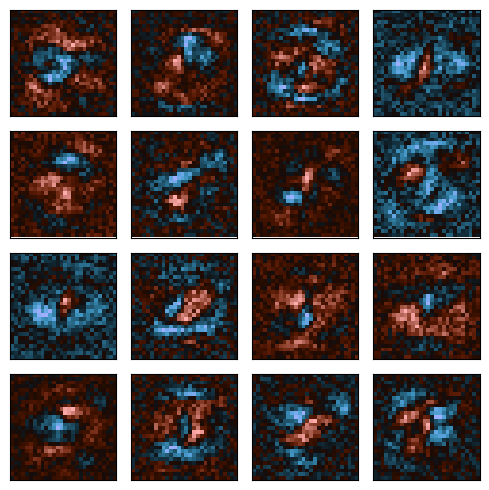

In [60]:
fig, axes = plt.subplots(4,4)
fig.set_figheight(5)
fig.set_figwidth(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    ax.matshow(model.W1[i].reshape(img_shape), cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

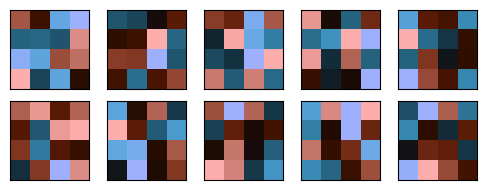

In [61]:
fig, axes = plt.subplots(2,5)
fig.set_figheight(2)
fig.set_figwidth(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    ax.matshow(model.W2[i].reshape((4,4)), cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()